In [34]:
from collections import namedtuple
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split
import csv
import matplotlib.pyplot as plt

In [22]:
variables = ["date", "meantempm", "meandewptm", "meanpressurem", "maxhumidity", "minhumidity", "maxtempm",
            "mintempm", "maxdewptm", "mindewptm", "maxpressurem", "minpressurem", "precipm"]

records = []

AnnualWeatherReport = namedtuple("AnnualWeatherReport", variables)

In [23]:
# read in the csv data into a pandas data frame and set the date as the index
with open("ottawa_raw_data.txt", "r") as raw_data:
    r = csv.reader(raw_data, delimiter=",")
    next(r)
    for row in r:
        records.append(AnnualWeatherReport(
            date=row[0],
            meantempm=row[1],
            meandewptm=row[2],
            meanpressurem=row[3],
            maxhumidity=row[4],
            minhumidity=row[5],
            maxtempm=row[6],
            mintempm=row[7],
            maxdewptm=row[8],
            mindewptm=row[9],
            maxpressurem=row[10],
            minpressurem=row[11],
            precipm=row[12]
        ))


df = pd.DataFrame(records, columns=variables).set_index('date')

def add_nth_day_prior_features(df, target_variable, days_prior):
    rows = df.shape[0]
    nth_prior_values = [None]*days_prior + [df[target_variable][i-days_prior] for i in range(days_prior, rows)]
    col_name = "{}_{}".format(target_variable, days_prior)
    df[col_name] = nth_prior_values


for target_variable in variables:
    if target_variable != 'date':
        for i in range(1, 4):
            add_nth_day_prior_features(df, target_variable, i)


variables_removed = [variable for variable in variables if variable not in ['meantempm', 'mintempm', 'maxtempm']]
variables_maintained = [col for col in df.columns if col not in variables_removed]

df = df[variables_maintained]

df = df.apply(pd.to_numeric, errors='coerce')
# print(df.info())

spread = df.describe().T
IQR = spread['75%'] - spread['25%']
spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))

# If Needed
for precip_col in ['precipm_1', 'precipm_2', 'precipm_3']:
    # create a boolean array of values representing nans
    missing_vals = pd.isnull(df[precip_col])
    df[precip_col][missing_vals] = 0

df = df.dropna()

c:\users\naman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantempm,149.0,41.993289,17.741194,3.0,30.0,39.0,54.0,95.0
maxtempm,149.0,15.080537,14.471555,-20.0,7.0,16.0,23.0,61.0
mintempm,149.0,72.040268,30.336375,9.0,64.0,85.0,93.0,100.0
meantempm_1,149.0,41.899329,17.708887,3.0,30.0,39.0,52.0,95.0
meantempm_2,149.0,41.704698,17.578974,3.0,30.0,39.0,52.0,95.0
meantempm_3,149.0,41.389262,17.288377,3.0,30.0,39.0,52.0,95.0
meandewptm_1,149.0,34.053691,16.226424,-4.4,22.7,33.9,42.9,80.9
meandewptm_2,149.0,33.891275,16.124046,-4.4,22.7,33.4,42.8,80.9
meandewptm_3,149.0,33.621477,15.827467,-4.4,22.7,33.2,42.4,80.9
meanpressurem_1,149.0,25.543624,15.675546,-15.0,14.0,27.0,34.0,66.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149 entries, 04/01/2020 to 31/05/2020
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   meantempm        149 non-null    int64  
 1   maxtempm         149 non-null    int64  
 2   mintempm         149 non-null    int64  
 3   meantempm_1      149 non-null    float64
 4   meantempm_2      149 non-null    float64
 5   meantempm_3      149 non-null    float64
 6   meandewptm_1     149 non-null    float64
 7   meandewptm_2     149 non-null    float64
 8   meandewptm_3     149 non-null    float64
 9   meanpressurem_1  149 non-null    float64
 10  meanpressurem_2  149 non-null    float64
 11  meanpressurem_3  149 non-null    float64
 12  maxhumidity_1    149 non-null    float64
 13  maxhumidity_2    149 non-null    float64
 14  maxhumidity_3    149 non-null    float64
 15  minhumidity_1    149 non-null    float64
 16  minhumidity_2    149 non-null    float64
 17  minhu

In [26]:
df = df.drop(['mintempm', 'maxtempm'], axis=1)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149 entries, 04/01/2020 to 31/05/2020
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   meantempm        149 non-null    int64  
 1   meantempm_1      149 non-null    float64
 2   meantempm_2      149 non-null    float64
 3   meantempm_3      149 non-null    float64
 4   meandewptm_1     149 non-null    float64
 5   meandewptm_2     149 non-null    float64
 6   meandewptm_3     149 non-null    float64
 7   meanpressurem_1  149 non-null    float64
 8   meanpressurem_2  149 non-null    float64
 9   meanpressurem_3  149 non-null    float64
 10  maxhumidity_1    149 non-null    float64
 11  maxhumidity_2    149 non-null    float64
 12  maxhumidity_3    149 non-null    float64
 13  minhumidity_1    149 non-null    float64
 14  minhumidity_2    149 non-null    float64
 15  minhumidity_3    149 non-null    float64
 16  maxtempm_1       149 non-null    float64
 17  maxte

In [28]:
X = df[[col for col in df.columns if col != 'meantempm']]
# y will be a pandas series of the meantempm
y = df['meantempm']

# split data into training set and a temporary set using sklearn.model_selection.traing_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=23)

# take the remaining 20% of data in X_tmp, y_tmp and split them evenly
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

In [29]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [30]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=50):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)


evaluations = []
STEPS = 200
for i in range(100):
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluation = regressor.evaluate(input_fn=wx_input_fn(X_val, y_val,
                                                         num_epochs=1,
                                                         shuffle=False),
                                    steps=1)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,

                                                               shuffle=False)))

evaluations[0]

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-36400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 36400 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 53.340256, step = 36400
INFO:tensorflow:global_step/sec: 77.2917
INFO:tensorflow:loss = 42.146183, step

{'average_loss': 99.79377,
 'label/mean': 47.333332,
 'loss': 99.79377,
 'prediction/mean': 45.038815,
 'global_step': 36600}

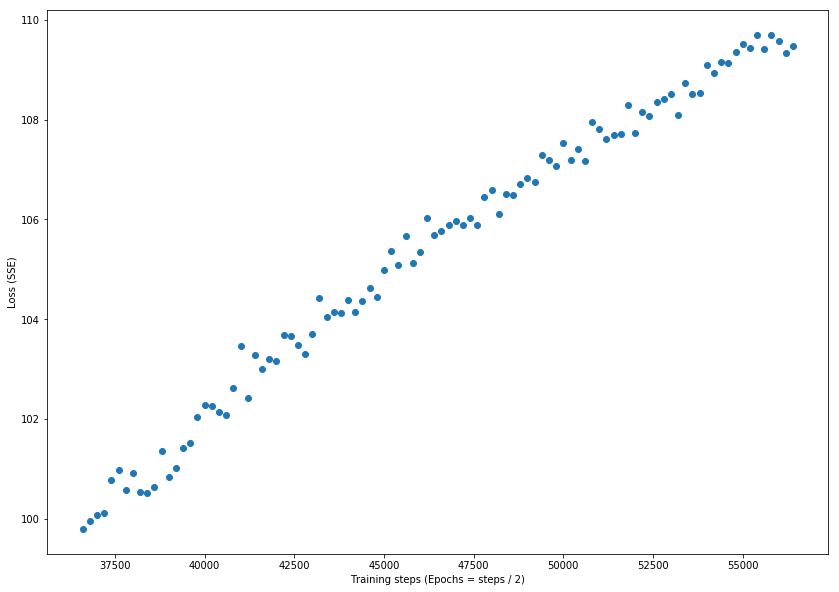

In [35]:
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 2)')
plt.ylabel('Loss (SSE)')
plt.show()


In [36]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-56400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [37]:
print("The Explained Variance: %.2f" % explained_variance_score(
                                            y_test, predictions))
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(
                                            y_test, predictions))
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(
                                            y_test, predictions))

The Explained Variance: 0.26
The Mean Absolute Error: 7.76 degrees Celcius
The Median Absolute Error: 8.39 degrees Celcius
